In [12]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)


In [13]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def get_matern_five_half(rho):
    def k(x,y):
        d=jnp.sqrt(jnp.sum((x-y)**2)+1e-8)
        return (1+jnp.sqrt(5)*d/rho+jnp.sqrt(5)*d**2/(rho**2))*jnp.exp(-jnp.sqrt(5)*d/rho)
    return k

def minus_div(f,arg_num=0):
    jac=jacfwd(f,argnums=arg_num)
    def divergence(x,y):
        return -1*jnp.trace(jac(x,y))
    return divergence

def k_laplacian(f,arg_num=0):
    return minus_div(grad(f,argnums=arg_num),arg_num=arg_num)

def laplacian(f,arg_num=0):
    hess= hessian(f,argnums=arg_num)
    def lap(x):
        return -1*jnp.trace(hess(x))
    return lap

k= get_gaussianRBF(0.05)
#k=get_matern_five_half(0.05)

k_lapx = k_laplacian(k,arg_num=0)
k_laplap = k_laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(None, 0)), in_axes=(0, None))
vec_k_lapx = jax.vmap(jax.vmap(k_lapx, in_axes=(None, 0)), in_axes=(0, None))
vec_k_laplap = jax.vmap(jax.vmap(k_laplap, in_axes=(None, 0)), in_axes=(0, None))

def true_solution_single(x):
    boundary_term = x[0]*(1-x[0])*x[1]*(1-x[1])
    interior = jnp.cos(5*jnp.pi*((0.5-x[0])**2 + (0.3*x[1])**2))
    return 10*boundary_term * interior

true_solution=jit(jax.vmap(true_solution_single,in_axes=0))
rhs_func = jit(jax.vmap(lambda u:laplacian(true_solution_single)(u)+true_solution_single(u)**2))

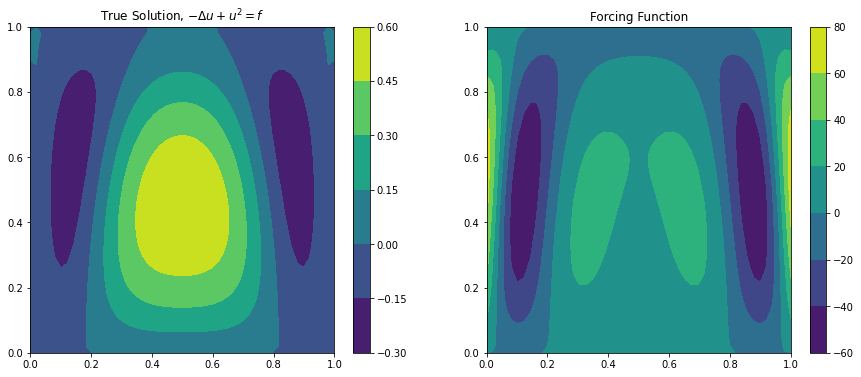

In [31]:
m_interp=50
xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
meshX,meshY=np.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([meshX.flatten(),meshY.flatten()]).T

interp_solution=(true_solution(interpolation_points)).reshape(m_interp,m_interp)
interp_rhs=(rhs_func(interpolation_points)).reshape(m_interp,m_interp)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(meshX,meshY,interp_solution)
ax1.set_title("True Solution, $-\Delta u + u^2 = f$")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(meshX,meshY,interp_rhs)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("Forcing Function")
plt.savefig("nonlinear_setup.png")
plt.show()


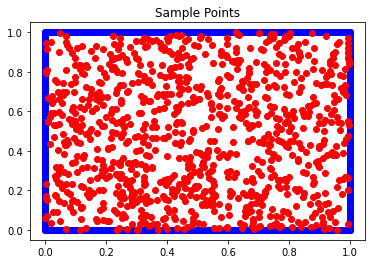

In [15]:
num_interior=1000
num_per_boundary=300

num_boundary=4*num_per_boundary


interior_points = jax.random.uniform(key,shape=(num_interior,2),minval=0,maxval=1)

boundary_point_samples=np.linspace(0,1,num_per_boundary)
boundary_points = np.hstack([
    np.vstack((np.zeros(num_per_boundary),boundary_point_samples)),
    np.vstack((np.ones(num_per_boundary),boundary_point_samples)),
    np.vstack((boundary_point_samples,np.ones(num_per_boundary))),
    np.vstack((boundary_point_samples,np.zeros(num_per_boundary)))
]).T

all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

In [16]:
Klaplap = vec_k_laplap(interior_points,interior_points) #Contribution from interior laplacian nodes to laplacian of output
K_xx = vec_k(interior_points,interior_points) #Contribution from interior points to interior points
K_lap_x = vec_k_lapx(interior_points,interior_points) #Contribution from interior points to laplacian
Klap_boundary = vec_k_lapx(interior_points,boundary_points) #Contribution from nodes at the boundary to points in interior
K_x_boundary = vec_k(interior_points,boundary_points)
K_BB = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [Klaplap,K_lap_x,Klap_boundary],
        [K_lap_x.T,K_xx,K_x_boundary],
        [Klap_boundary.T,K_x_boundary.T,K_BB]
    ]
)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

In [17]:
nugget=1e-4
Kmat=K_full+nugget*jnp.diag(jnp.diag(K_full))


def residual(coef):
    func_outputs=K_full@coef

    lapvals=func_outputs[:num_interior]
    funcvals=func_outputs[num_interior:2*num_interior]
    equation_vals = lapvals + funcvals**2
    boundary_vals = func_outputs[-num_boundary:]
    return rhs_total - jnp.hstack([equation_vals,boundary_vals])

lam=1e-4
def loss(coef):
    return (1/2)*jnp.sum(residual(coef)**2)+1/2*lam*coef@Kmat@coef

lossgrad=grad(loss)

losshessian=hessian(loss)

In [21]:
c=jnp.zeros(len(K_full))
for i in range(20):
    H=losshessian(c)
    gradient=lossgrad(c)
    if jnp.linalg.norm(gradient)**2<=1e-5:
        print(jnp.linalg.norm(gradient)**2)
        break
    c=c-jnp.linalg.solve(H,gradient)

    print(f"{i}:Loss",loss(c))
    print(f"{i}Residual norm squared",jnp.sum(residual(c)**2))
    print(f"{i}Gradient norm",jnp.linalg.norm(gradient))

0:Loss 243814.41866664655
0Residual norm squared 479240.57185330935
0Gradient norm 210678272.09347218
1:Loss 17921.28494766665
1Residual norm squared 33602.7242811281
1Gradient norm 89762514.82557149
2:Loss 89631.13531126722
2Residual norm squared 179173.44381408003
2Gradient norm 6020321.050501755
3:Loss 316.88211903855296
3Residual norm squared 598.8231254618573
3Gradient norm 59606693.122574575
4:Loss 112.8453482037663
4Residual norm squared 224.66998060131377
4Gradient norm 1048591.095906869
5:Loss 0.33520141907915646
5Residual norm squared 0.5438777130566418
5Gradient norm 1968122.3559824605
6:Loss 0.21575186565185706
6Residual norm squared 0.3463593992885189
6Gradient norm 34993.99507933792
7:Loss 0.2147345911545313
7Residual norm squared 0.3462198870688571
7Gradient norm 2001.3677362987926
8:Loss 0.21467623774205563
8Residual norm squared 0.346241244294173
8Gradient norm 0.20801388163989032
2.5235391580935727e-08


In [22]:
XX,YY=jnp.meshgrid(xgrid,ygrid)
interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

interp_k = jnp.block(
    [
        [
            vec_k_lapx(interpolation_points,interior_points),
            vec_k(interpolation_points,interior_points),
            vec_k(interpolation_points,boundary_points)
            ]
    ]
)


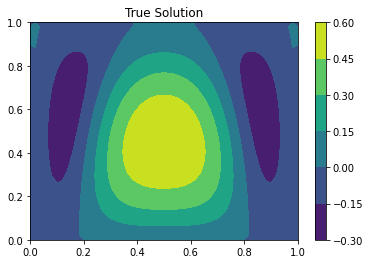

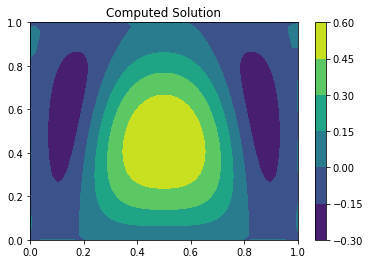

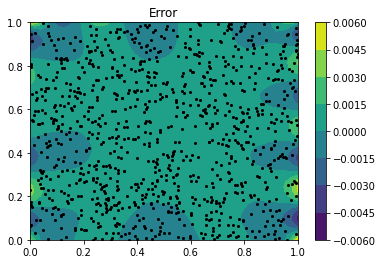

In [23]:
plt.title("True Solution")
plt.contourf(meshX,meshY,interp_solution)
plt.colorbar()
plt.show()

u_interp=(interp_k@c).reshape(m_interp,m_interp)
plt.title("Computed Solution")
plt.contourf(meshX,meshY,u_interp)
plt.colorbar()
plt.show()


plt.title("Error")
plt.contourf(meshX,meshY,interp_solution-u_interp)
plt.colorbar()
plt.scatter(interior_points[:,0],interior_points[:,1],s=4,c='black')
plt.show()

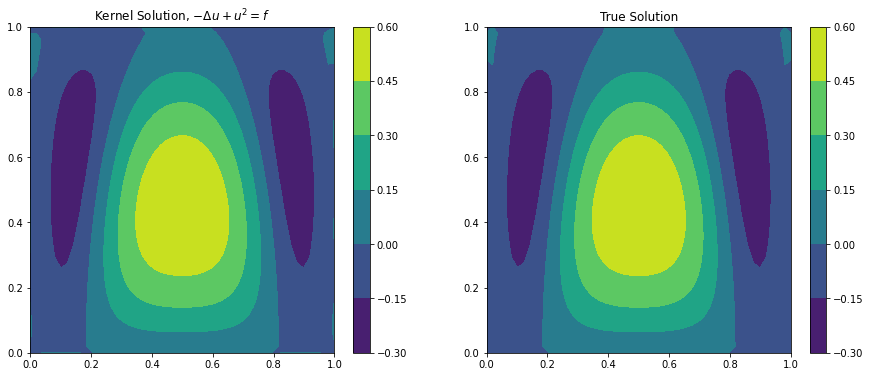

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,u_interp)
ax1.set_title("Kernel Solution, $-\Delta u + u^2 = f$")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_solution)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("True Solution")
plt.savefig("nonlinear_solution.png")
plt.show()


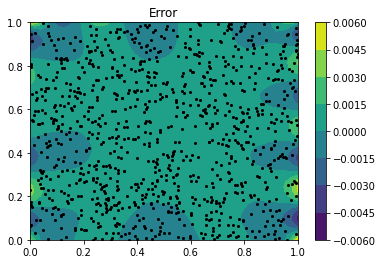

In [27]:
plt.title("Error")
plt.contourf(meshX,meshY,interp_solution-u_interp)
plt.colorbar()
plt.scatter(interior_points[:,0],interior_points[:,1],s=4,c='black')
plt.savefig("nonlinear_error.png")
plt.show()

In [24]:
jnp.sqrt(jnp.mean((u_interp-interp_solution)**2))

Array(0.00070596, dtype=float64)

In [25]:
jnp.max(jnp.abs(u_interp-interp_solution))

Array(0.00584579, dtype=float64)